# Expectation-Maximization algorithm

Here, we will derive and implement formulas for Gaussian Mixture Model one of the most commonly used methods for performing soft clustering of the data. 

### Installation

We will need ```numpy```, ```scikit-learn```, ```matplotlib``` libraries for this assignment

In [1]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. 

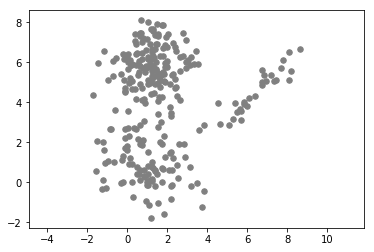

In [2]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [3]:
from scipy.stats import multivariate_normal
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    for i in range(C):
        model = multivariate_normal(mean=mu[i,:], cov=sigma[i,:])
        gamma[:,i] = model.pdf(X)
    gamma *= pi
    gamma = gamma/gamma.sum(axis=1, keepdims=True)
    return gamma

In [4]:
gamma = E_step(X, pi0, mu0, sigma0)
print(gamma)

[[9.89984413e-001 1.00155874e-002 2.51121517e-016]
 [9.77802155e-001 2.21978447e-002 1.07229089e-014]
 [9.78228436e-001 2.17715636e-002 6.65282252e-016]
 [9.99470994e-001 5.29005851e-004 7.87626322e-024]
 [9.99482344e-001 5.17656126e-004 3.24388347e-026]
 [6.83857110e-005 9.99931614e-001 1.15852408e-020]
 [1.50729715e-036 1.00000000e+000 2.89692453e-057]
 [1.83115480e-001 8.16884375e-001 1.44924709e-007]
 [9.60027562e-001 3.99724376e-002 7.78636239e-013]
 [4.35705967e-001 5.33717874e-001 3.05761590e-002]
 [4.22427127e-001 5.74733674e-001 2.83919872e-003]
 [9.88286857e-001 1.17131434e-002 1.83043464e-016]
 [5.42939168e-001 4.56729246e-001 3.31586125e-004]
 [1.08502493e-001 8.91497507e-001 8.73826666e-032]
 [6.27715071e-004 9.99372285e-001 3.50074230e-024]
 [8.65821552e-001 1.34178197e-001 2.50489977e-007]
 [1.34635440e-010 1.00000000e+000 1.69888046e-010]
 [9.98574647e-001 1.42535271e-003 3.60305312e-021]
 [5.82682916e-001 4.17155213e-001 1.61870957e-004]
 [7.17431881e-003 9.92825681e-0

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [5]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    pi = np.zeros(C)
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))
    for k in range(C):
        q_sum = gamma[:,k].sum()
        mu[k,:] = (X*gamma[:,k][:, np.newaxis]).sum(axis=0)/ q_sum
        sigma[k,:] = np.sum([gamma[i,k] * np.outer(X[i] - mu[k], X[i] - mu[k]) for i in range(N)], axis=0) / q_sum
        pi[k] = q_sum / N

    return pi, mu, sigma

In [7]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
print(pi, mu, sigma)

[0.44702322 0.55076245 0.00221433] [[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]] [[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]


### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [8]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    loss = 0
    for k in range(C):
        dist = multivariate_normal(mu[k], sigma[k],allow_singular=True)
        for n in range(N):
            loss += gamma[n,k]*(np.log(pi[k]+0.00001)+dist.logpdf(X[n,:])-np.log(gamma[n,k]+0.000001))

    return loss

In [9]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print(loss)

-1213.96560953364


In [10]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print(pi, mu, sigma , loss)

[0.46383545 0.52768499 0.00847956] [[ 1.07499213  5.85685648]
 [ 2.22864219  2.45133965]
 [-1.22344612  0.84643644]] [[[ 0.68405518  0.17863387]
  [ 0.17863387  1.3030211 ]]

 [[ 5.86816538  2.66859884]
  [ 2.66859884  5.09531312]]

 [[ 0.02252806 -0.06231391]
  [-0.06231391  0.97861765]]] -1150.505407633942


### Bringing it all together

Now that we have E step, M step and VLB, we can implement training loop. We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L_i}}{\mathcal{L_{i-1}}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

<b>Task 4:</b> Implement training procedure

In [11]:
import math
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10, verbose=False):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -9999999
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            pi = np.array([1.0/C]*C,dtype=np.float32)
            mu = np.random.rand(C, d)
            sigma_ = np.random.rand(C, d, d)
            sigma = np.array([np.dot(A, A.T) for A in sigma_])
            prev_loss = None
            for i in range(max_iter):
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                if not math.isnan(loss) and loss > best_loss:
                    best_loss = loss
                    best_mu = mu
                    best_pi = pi
                    best_sigma = sigma
                if verbose:
                    print("Iteration {}, loss: {}".format(i, loss))

                if prev_loss is not None:
                    diff = np.abs(loss - prev_loss)
                    if diff < rtol:
                        break
                prev_loss = loss

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass
        except Exception as e:
            print(e)
            print(sigma, mu, pi)

    return best_loss, best_pi, best_mu, best_sigma

In [13]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3, verbose=True)
print(best_loss)

Iteration 0, loss: -1208.0560699500675
Iteration 1, loss: -1196.0226717169194
Iteration 2, loss: -1189.6701990117422
Iteration 3, loss: -1184.0743637321314
Iteration 4, loss: -1178.4943990852976
Iteration 5, loss: -1172.5922808047565
Iteration 6, loss: -1166.8431982509842
Iteration 7, loss: -1162.2840641424807
Iteration 8, loss: -1159.5780682000154
Iteration 9, loss: -1158.3418965168237
Iteration 10, loss: -1157.8353784074936
Iteration 11, loss: -1157.61658546643
Iteration 12, loss: -1157.5069449434384
Iteration 13, loss: -1157.4403265639594
Iteration 14, loss: -1157.3911469695524
Iteration 15, loss: -1157.348511281875
Iteration 16, loss: -1157.307049817674
Iteration 17, loss: -1157.2634989374876
Iteration 18, loss: -1157.2153939335196
Iteration 19, loss: -1157.1607042883518
Iteration 20, loss: -1157.098091260167
Iteration 21, loss: -1157.0276392520675
Iteration 22, loss: -1156.9515584013022
Iteration 23, loss: -1156.8738791198002
Iteration 24, loss: -1156.79878414951
Iteration 25, los

Iteration 82, loss: -1063.8040964451488
Iteration 0, loss: -1210.1692970036997
Iteration 1, loss: -1156.5651483797517
Singular matrix: components collapsed
Iteration 0, loss: -1239.7707017046228
Iteration 1, loss: -1231.237543138721
Iteration 2, loss: -1226.3070292698112
Iteration 3, loss: -1218.8317923433717
Iteration 4, loss: -1211.068951138456
Iteration 5, loss: -1204.3904989015837
Iteration 6, loss: -1198.1022642243909
Iteration 7, loss: -1190.7392190874791
Iteration 8, loss: -1182.5838473443746
Iteration 9, loss: -1169.5480883481125
Iteration 10, loss: -1171.3951750360452
Singular matrix: components collapsed
Iteration 0, loss: -1254.4510059548759
Iteration 1, loss: -1165.1224600138733
Iteration 2, loss: -1149.9593343141487
Iteration 3, loss: -1144.7666773722765
Iteration 4, loss: -1140.0046297014546
Iteration 5, loss: -1135.128082336509
Iteration 6, loss: -1131.344516078198
Iteration 7, loss: -1129.0126743459616
Iteration 8, loss: -1127.1795208722453
Iteration 9, loss: -1126.0885

If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


In [ ]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()